In [23]:
from scipy.optimize import minimize
import json
import numpy as np
from random import random
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

from qiskit import transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator


In [2]:
def printFullSpectrum(numQubits, Hamiltonian):
    for n in range(2**numQubits):
        num = [int(b) for b in list(bin(n)[2:])]
        state = [0]*(numQubits - len(num)) + num
        print(state, Hamiltonian(state))

In [4]:
def Hamiltonian(state): 
    return state[0] + state[1] - state[0]*state[1]

In [5]:
printFullSpectrum(2, Hamiltonian)

[0, 0] 0
[0, 1] 1
[1, 0] 1
[1, 1] 1


In [128]:
def MeasureTrialState(parameters, numQubits):
    qc = QuantumCircuit(numQubits, numQubits)
    norm = 0
    for i in range(2**numQubits):
        norm += np.abs(parameters[i]) ** 2

    normalized_parameters = []
    #check if this is correct: make sure that the arbitrary state to be prepared is normalized
    for i in range(2**numQubits):
        normalized_parameters.append(parameters[i]/np.sqrt(norm))

#     print(normalized_parameters)
    qc.initialize(normalized_parameters)
    qc.measure_all()
    return qc

In [129]:
qc = MeasureTrialState([1,1], 1)

In [130]:
def localSimulator(operation, parameters, numQubits, shots, trim = False):
    results = {}
    simulator = AerSimulator()
    qc = operation(parameters = parameters, numQubits = numQubits)
    circuit_simulator = simulator.run(transpile(qc,simulator), shots=shots)
    results = circuit_simulator.result().get_counts()
    
    if trim == True:

        for state in list(results.keys()):
            if results[state] < 1e-2: del(results[state])

    return results
    

In [132]:
def averageEnergy(parameters, numQubits, Hamiltonian, shots = 20):

    # Prepare and measure the state many times
    results = localSimulator(MeasureTrialState, parameters, numQubits, shots)

    # Calculate and return the average energy of this set of measurements
    averageEnergy = 0

    for bits in results.keys():
        x = bits.split(' ')
        item = list(x[0].strip(" "))
        state = [int(i) for i in item]
        averageEnergy += Hamiltonian(state) * results[bits]
    
    return averageEnergy

In [133]:
def VQE(numQubits, Hamiltonian): 
    
    parameters = [1 / 2**numQubits] * (2**numQubits)
    
    return minimize(averageEnergy, parameters, args = (numQubits, Hamiltonian), method = "SLSQP")

In [134]:
result = VQE(2, Hamiltonian)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 20
       x: [-3.315e+05 -4.099e+07  5.979e+07 -2.849e+07]
     nit: 7
     jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 95
    njev: 7


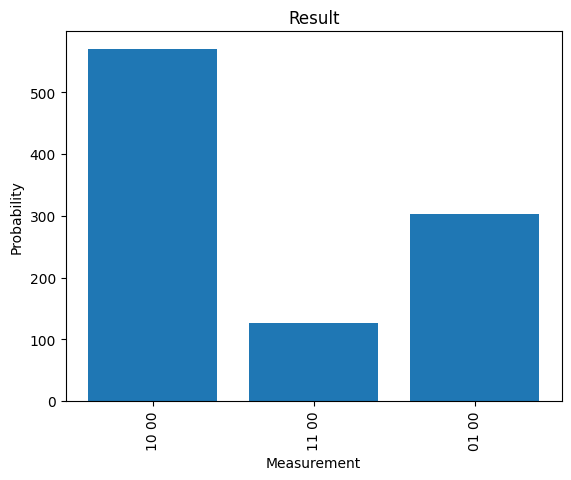

In [136]:
print(result)
results = localSimulator(MeasureTrialState, result.x, 2, 1000)

plt.bar(results.keys(), results.values())

plt.title("Result")
plt.xlabel("Measurement")
plt.ylabel("Probability")

plt.xticks(rotation = 90)

plt.show()